In [1]:
import sys
spath = '../scripts'
sys.path.insert(0,spath)

from models import *
from notebook import *

### Loading data from drive

In [2]:
data_folder = '/export/b03/carlosc/data/2020/augmented'
embedding_dim = 128

dev_rttm     = data_folder + '/callhome/callhome1/augmented_0/1.0_0.5_0.5/' + str(embedding_dim) + '/ref.rttm'
dev_segments = data_folder + '/callhome/callhome1/augmented_0/1.0_0.5_0.5/' + str(embedding_dim) + '/segments'
dev_ivectors = data_folder + '/callhome/callhome1/augmented_0/1.0_0.5_0.5/' + str(embedding_dim) + '/exp/make_ivectors/ivector.txt'
dev_files_segments = get_rttm_segments_features(dev_rttm, dev_segments, dev_ivectors)

eval_rttm     = data_folder + '/callhome/callhome2/augmented_0/1.0_0.5_0.5/' + str(embedding_dim) + '/ref.rttm'
eval_segments = data_folder + '/callhome/callhome2/augmented_0/1.0_0.5_0.5/' + str(embedding_dim) + '/segments'
eval_ivectors = data_folder + '/callhome/callhome2/augmented_0/1.0_0.5_0.5/' + str(embedding_dim) + '/exp/make_ivectors/ivector.txt'
eval_files_segments = get_rttm_segments_features(eval_rttm, eval_segments, eval_ivectors)

### Filtering data

In [3]:
dev_files_segments_lim = limit_segments_speakers_length(dev_files_segments, 1, log = True)
eval_files_segments_lim = limit_segments_speakers_length(eval_files_segments, 1, log = True)

Kept 39533 of 70546: 0.5603861310350693
Kept 38688 of 66651: 0.5804564072557051


In [4]:
from torch.utils.data import Dataset

def invert_speaker_weights(speakers_weights):
    weight_sum = sum(speakers_weights.values())
    weight_count = len(speakers_weights.values())
    speakers_weights_inverse = {}
    for speaker_name, weight in speakers_weights.items():
        speakers_weights_inverse[speaker_name] = (weight_sum - speakers_weights[speaker_name]) / ((weight_count - 1) * weight_sum)
    return speakers_weights_inverse

class Files_dataset(Dataset):
    def __init__(self,
                 embedding_dim,
                 files_segments,
                 files_speakers = {},
                 models_generation_lengths = [3],
                 models_container_length = 2,
                 include_zeros = True,
                 include_overlaps = False,
                 feature = 'ivectors',
                 zeros_multiplier = 1.0):
        self.embedding_dim = embedding_dim
        self.files_segments = files_segments
        self.files_speakers = {}
        for file_id in self.files_segments:
            self.files_speakers[file_id] = files_speakers[file_id] \
            if file_id in files_speakers \
            else get_first_speakers(self.files_segments[file_id])
        self.models_generation_lengths = models_generation_lengths
        self.models_container_length = models_container_length
        self.include_zeros = include_zeros
        self.include_overlaps = include_overlaps
        self.feature = feature
        self.zeros_multiplier = zeros_multiplier
        self.speakers_segments_indexes = {}
        self.speakers_models = {}
        self.speakers_models_combinations_length = {}
        self.complete_turns = {}
        self.speakers_permutations = {}
        self.speakers_weights = {}
        self.lookup = []
        self.length = 0
        for file_id, segments in self.files_segments.items():
            self.speakers_segments_indexes[file_id] = get_speakers_segments_indexes(enumerate(segments))
            self.speakers_models[file_id] = get_speakers_models(segments,
                                                                self.speakers_segments_indexes[file_id],
                                                                self.models_generation_lengths,
                                                                self.files_speakers[file_id])
            self.speakers_models_combinations_length[file_id] = len(self.models_generation_lengths) ** len(self.speakers_models[file_id].keys())            
            self.complete_turns[file_id] = 2
            
            length = self.complete_turns[file_id] * self.speakers_models_combinations_length[file_id] * len(segments)
            self.speakers_permutations[file_id] = Permutations(self.speakers_models[file_id].keys(),
                                                               length,
                                                               self.models_container_length,
                                                               self.include_zeros)
            speakers_weights = self.speakers_permutations[file_id].get_speakers_names_counts()
            if self.include_zeros and '0' in speakers_weights:
                speakers_weights['0'] *= (1 / self.zeros_multiplier)
            self.speakers_weights[file_id] = invert_speaker_weights(speakers_weights)

            self.lookup.append({ 'file_id': file_id, 'onset': self.length, 'end': self.length + length - 1 })
            self.length += length

    def __len__(self):
        return self.length

    def __getitem__(self, key):
        lookup = [value for value in self.lookup if value['onset'] <= key and key <= value['end']][0]
        file_id = lookup['file_id']
        index = key - lookup['onset']
        segments = self.files_segments[file_id]
        permutation = self.speakers_permutations[file_id][index]
        _, turn_index = divmod(index, self.speakers_models_combinations_length[file_id] * len(segments))
        
        model_index, segment_index = divmod(turn_index, len(segments))
        
        models = {}
        models_speakers_names = list(self.speakers_models[file_id].keys())
        remainder = model_index
        for speaker_name_index, speaker_name in enumerate(models_speakers_names):
            models_lengths = [len(self.speakers_models[file_id][speaker_name].keys()) for speaker_name in models_speakers_names[speaker_name_index + 1:]]
            if index != len(models_speakers_names) - 1:
                model_index, remainder = divmod(remainder, int(np.prod(models_lengths)))
            else:
                model_index = remainder
            models[speaker_name] = self.speakers_models[file_id][speaker_name][list(self.speakers_models[file_id][speaker_name].keys())[model_index]]

        models_container = [models[speaker_name] if speaker_name != '0' else { 'ivectors': [Ivector(np.random.uniform(-0.1, 0.1, self.embedding_dim).astype(np.float32))] } for speaker_name in permutation]
        
        segment = segments[segment_index]
        segment_speakers_names = [speaker.get_name() for speaker in segment.get_speakers()]
        
        x = [embeddings[self.feature][0].get_value() for embeddings in models_container + [{ 'ivectors': segment.get_ivectors() }]]
        y = np.asarray([speaker_name in segment_speakers_names for speaker_name in permutation], dtype = np.float32)
        w =  np.asarray([self.speakers_weights[file_id][speaker_name] for speaker_name in permutation], dtype = np.float32)
        return x, y, w

In [5]:
import torch.nn as nn

'''class Model(nn.Module):
    def __init__(self, b, M):
        super(Model, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.Conv1d((M + 1), M ** 3, 3),
            nn.ReLU(),
            nn.Conv1d(M ** 3, M ** 2, 3),
            nn.ReLU(),
            nn.Conv1d(M ** 2, M, 3),
            nn.ReLU(),
        )
        self.lstm1 = nn.Sequential(
            nn.LSTM(b - 6, 32, bidirectional = True),
        )
        self.fc1 = nn.Sequential(
            nn.Linear(M * 2 * 32, M * 16),
            nn.ReLU(),
            nn.Linear(M * 16, M * 8),
            nn.ReLU(),
            nn.Linear(M * 8, M),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = torch.stack(x, 1)
        x = self.cnn1(x)
        x, _ = self.lstm1(x)
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        return x'''

class Model(nn.Module):
    def __init__(self, b, M):
        super(Model, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.Conv1d((M + 1), M ** 3, 5),
            nn.ReLU(),
            nn.Conv1d(M ** 3, M ** 2, 3),
            nn.ReLU(),
            nn.Conv1d(M ** 2, M, 3),
            nn.ReLU(),
        )
        self.lstm1 = nn.Sequential(
            nn.LSTM(b - 8, 8, bidirectional = True),
        )
        self.fc1 = nn.Sequential(
            nn.Linear(M * 2 * 8, M * 4),
            nn.ReLU(),
            nn.Linear(M * 4, M * 2),
            nn.ReLU(),
            nn.Linear(M * 2, M),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = torch.stack(x, 1)
        x = self.cnn1(x)
        x, _ = self.lstm1(x)
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        return x

In [6]:
%matplotlib notebook
import matplotlib.pyplot as plt

class Train_graph:
    def __init__(self, training_loss = 1):
        self.step = 0
        self.training_losses_x = [self.step - 1, self.step]
        self.training_losses_y = [training_loss, training_loss]
        self.validation_losses_x = None
        self.validation_losses_y = None
        self.fig = plt.figure()
        self.ax = self.fig.add_subplot()
        self.training_line, = self.ax.plot(self.training_losses_x, self.training_losses_y, '--', label = 'Training')
        self.validation_line = None
        self.ax.set_ylim(0, training_loss)
        self.ax.set_xlabel('Epoch')
        self.ax.set_ylabel('Loss')
        self.ax.legend()
        self.fig.canvas.draw()
        self.fig.canvas.flush_events()
    def draw(self, training_loss, validaton_loss = None):
        self.step += 1
        self.training_losses_x.append(self.step)
        self.training_losses_y.append(training_loss)
        self.training_line.set_xdata(self.training_losses_x)
        self.training_line.set_ydata(self.training_losses_y)
        if validation_loss is not None:
            if self.validation_line is None:
                self.validation_losses_x = [self.step - 1]
                self.validation_losses_y = [validation_loss]
                self.validation_line = self.ax.plot(self.validation_losses_x, self.validation_losses_y, label = 'Validation')[0]
                self.ax.legend()
            self.validation_losses_x.append(self.step)
            self.validation_losses_y.append(validation_loss)
            self.validation_line.set_xdata(self.validation_losses_x)
            self.validation_line.set_ydata(self.validation_losses_y)
        self.ax.set_xlim(0, self.step + 1)
        self.fig.canvas.draw()
        self.fig.canvas.flush_events()

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-35ydqzve because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


<IPython.core.display.Javascript object>


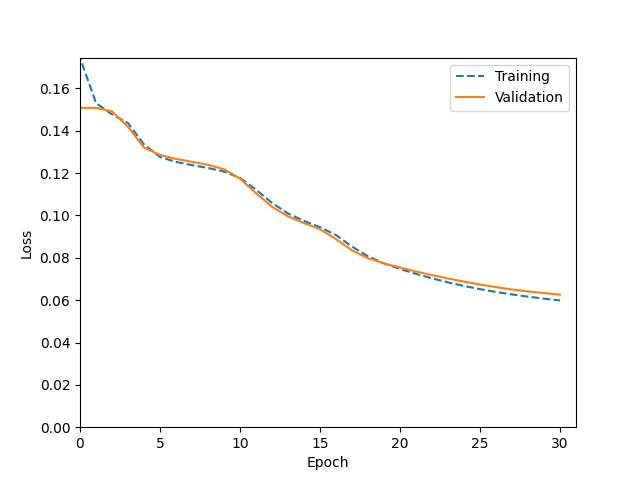

In [7]:
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import random

import numpy as np

seed = 19970917 #25005233 19970917
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

dev_files_speakers = get_first_speakers(dev_files_segments, 2)
eval_files_speakers = get_first_speakers(eval_files_segments, 2)

dev_files_ids = list(dev_files_segments_lim.keys())
dev_validation_files_ids = random.sample(dev_files_ids, int(len(dev_files_ids) * 0.3))
dev_train_files_ids = [file_id for file_id in dev_files_ids if file_id not in dev_validation_files_ids]

dev_train_files_segments = {}
for file_id in dev_train_files_ids:
    dev_train_files_segments[file_id] = dev_files_segments_lim[file_id]
dev_validation_files_segments = {}
for file_id in dev_validation_files_ids:
    dev_validation_files_segments[file_id] = dev_files_segments_lim[file_id]

dev_train_dataset = Files_dataset(embedding_dim, dev_train_files_segments, {}, [3])
dev_validation_dataset = Files_dataset(embedding_dim, dev_validation_files_segments, {}, [3])

dev_train_dataloader = DataLoader(dev_train_dataset, batch_size = 32, num_workers = 8)
dev_validation_dataloader = DataLoader(dev_validation_dataset, batch_size = 32, num_workers = 8)

net = Model(embedding_dim, 2).to(device, non_blocking = True)
optimizer = optim.Adam(net.parameters(), lr = 0.0001)

losses = []
with torch.no_grad():
    for dataloader in [dev_train_dataloader]:
        for x, y, w in dataloader:
            x = [tensor.to(device, non_blocking = True).float() for tensor in x]
            y = y.to(device, non_blocking = True).float()
            w = w.to(device, non_blocking = True).float()
            criterion = nn.BCELoss(w)
            y_ = net(x)
            loss = criterion(y_, y)
            losses.append(loss.data)
train_loss = (np.sum(losses) / len(losses)).cpu()

train_graph = Train_graph(train_loss)

for train_dataloader, validation_dataloader in [(dev_train_dataloader, dev_validation_dataloader)]:
    for epoch in range(30):
        losses = []
        for x, y, w in train_dataloader:
            x = [tensor.to(device, non_blocking = True).float() for tensor in x]
            y = y.to(device, non_blocking = True).float()
            w = w.to(device, non_blocking = True).float()

            criterion = nn.BCELoss(w)
            net.zero_grad()
            y_ = net(x)
            loss = criterion(y_, y)
            loss.backward()
            optimizer.step()

            losses.append(loss.data)
        train_loss = np.sum(losses) / len(losses)
        
        validation_losses = []
        with torch.no_grad():
            for x, y, w in validation_dataloader:
                x = [tensor.to(device, non_blocking = True).float() for tensor in x]
                y = y.to(device, non_blocking = True).float()
                w = w.to(device, non_blocking = True).float()
                criterion = nn.BCELoss(w)
                y_ = net(x)
                loss = criterion(y_, y)
                
                validation_losses.append(loss)
        validation_loss = np.sum(validation_losses) / len(validation_losses)
        
        train_graph.draw(train_loss, validation_loss)
        print(train_loss, validation_loss, end = '\r')

In [8]:
class File_dataset(Dataset):
    def __init__(self,
                 embedding_dim,
                 segments,
                 speakers = [],
                 models_generation_length = 3,
                 models_container_length = 2,
                 feature = 'ivectors'):
        self.embedding_dim = embedding_dim
        self.segments = segments
        self.speakers = speakers[:models_container_length]
        if len(self.speakers) < models_container_length:
            speakers = [speaker for speaker in get_first_speakers(segments) if speaker not in self.speakers]
            self.speakers += speakers[:models_container_length - len(self.speakers)]
            self.speakers += ['0' for i in range(models_container_length - len(self.speakers))]                
        self.models_generation_length = models_generation_length
        self.models_container_length = models_container_length
        self.feature = feature
        self.length = len(segments)
        
        self.speakers_segments_indexes = get_speakers_segments_indexes(enumerate(segments))
        self.speakers_models = get_speakers_models(segments,
                                                   self.speakers_segments_indexes,
                                                   [self.models_generation_length],
                                                   self.speakers)
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, key):
        segment = self.segments[key]
        print(self.speakers, segment.get_turn_onset(), [speaker.get_name() for speaker in segment.get_speakers()], end = '')
        speakers_embeddings = [self.speakers_models[speaker][self.models_generation_length][self.feature][0].get_value() for speaker in self.speakers]
        x = speakers_embeddings + [segment.get_ivectors()[0].get_value()]
        return x
    
def net_scoring(x, net, device):
    with torch.no_grad():
        x = [tensor.to(device) for tensor in x]
        y_ = net(x)
        return y_.cpu().numpy()[0]

for file_id, segments in eval_files_segments_lim.items():
    print(file_id)
    file_dataset = File_dataset(embedding_dim, segments)
    file_dataloader = DataLoader(file_dataset)
    for x in file_dataloader:
        print(net_scoring(x, net, device))

iaab
['B', 'A'] 0.0 ['B'][0.9516981  0.03889922]
['B', 'A'] 7.557 ['B'][0.9521247  0.03651864]
['B', 'A'] 8.057 ['B'][0.9550277  0.03062726]
['B', 'A'] 8.897 ['A'][0.02407862 0.9209352 ]
['B', 'A'] 9.397 ['A'][0.01677287 0.92175275]
['B', 'A'] 15.284 ['B'][0.91877574 0.03460526]
['B', 'A'] 15.784 ['B'][0.798205   0.07507776]
['B', 'A'] 16.384 ['A'][0.02752986 0.9216754 ]
['B', 'A'] 16.884 ['A'][0.02300968 0.9225161 ]
['B', 'A'] 24.442 ['A'][0.02444618 0.92117894]
['B', 'A'] 24.942 ['A'][0.01721291 0.91290927]
['B', 'A'] 26.202 ['B'][0.92366916 0.02899631]
['B', 'A'] 26.702 ['B'][0.93219006 0.03212273]
['B', 'A'] 31.577 ['B'][0.8940169  0.04092124]
['B', 'A'] 32.077 ['B'][0.90748334 0.04377367]
['B', 'A'] 32.577 ['B'][0.623854   0.09515661]
['B', 'A'] 33.217 ['A'][0.01912065 0.912205  ]
['B', 'A'] 34.397 ['B'][0.7325428 0.1670191]
['B', 'A'] 34.897 ['B'][0.87747633 0.07183381]
['B', 'A'] 36.927 ['B'][0.8816691  0.05857259]
['B', 'A'] 37.427 ['B'][0.88250136 0.04461241]
['B', 'A'] 42.439

['A', 'B'] 321.981 ['B'][0.05524637 0.4869092 ]
['A', 'B'] 322.481 ['B'][0.00566029 0.7984123 ]
['A', 'B'] 322.981 ['B'][0.01480446 0.7342304 ]
['A', 'B'] 323.481 ['B'][0.03499999 0.43136746]
['A', 'B'] 323.981 ['B'][0.06499885 0.49918392]
['A', 'B'] 324.481 ['B'][0.07021117 0.55236495]
['A', 'B'] 324.981 ['B'][0.02212821 0.55380094]
['A', 'B'] 325.481 ['B'][0.0069821 0.7073763]
['A', 'B'] 325.981 ['B'][0.02378368 0.67643267]
['A', 'B'] 326.481 ['B'][0.02846096 0.47102064]
['A', 'B'] 327.601 ['B'][0.03894721 0.65697587]
['A', 'B'] 330.48 ['A'][0.58093363 0.06159033]
['A', 'B'] 331.16 ['B'][0.00871817 0.73103476]
['A', 'B'] 331.66 ['B'][0.00986189 0.77583706]
['A', 'B'] 332.16 ['B'][0.03299417 0.66459435]
['A', 'B'] 334.57 ['A'][0.6738837 0.0314358]
['A', 'B'] 335.07 ['A'][0.52754086 0.03177626]
['A', 'B'] 335.57 ['A'][0.34982812 0.06856985]
['A', 'B'] 337.86 ['B'][0.01268347 0.80674356]
['A', 'B'] 338.36 ['B'][0.00924284 0.82973593]
['A', 'B'] 338.86 ['B'][0.04738872 0.75733614]
['A', 

['B', 'A'] 54.005 ['B'][0.6277431 0.2600727]
['B', 'A'] 54.505 ['B'][0.527278 0.560153]
['B', 'A'] 55.005 ['B'][0.58378243 0.25215572]
['B', 'A'] 55.505 ['B'][0.72835165 0.21121642]
['B', 'A'] 56.005 ['B'][0.5030958 0.5348906]
['B', 'A'] 56.505 ['B'][0.22029646 0.80784315]
['B', 'A'] 57.695 ['A'][0.00685969 0.8837029 ]
['B', 'A'] 58.195 ['A'][0.02364656 0.7706494 ]
['B', 'A'] 58.695 ['A'][0.02632443 0.6242288 ]
['B', 'A'] 59.195 ['A'][0.01667477 0.8098045 ]
['B', 'A'] 59.695 ['A'][0.01173898 0.83378536]
['B', 'A'] 60.195 ['A'][0.01523821 0.73284495]
['B', 'A'] 60.695 ['A'][0.02022259 0.89962983]
['B', 'A'] 61.195 ['A'][0.02160552 0.9018924 ]
['B', 'A'] 61.695 ['A'][0.01516098 0.9060625 ]
['B', 'A'] 62.195 ['A'][0.00591337 0.89979184]
['B', 'A'] 62.695 ['A'][0.01184091 0.88518685]
['B', 'A'] 63.195 ['A'][0.02001502 0.89129287]
['B', 'A'] 63.695 ['A'][0.02179528 0.88544035]
['B', 'A'] 64.195 ['A'][0.02326917 0.80206496]
['B', 'A'] 64.695 ['A'][0.01566141 0.80356115]
['B', 'A'] 65.195 ['A

['B', 'A'] 12.02 ['A'][0.01822024 0.9053325 ]
['B', 'A'] 12.52 ['A'][0.01341644 0.90526253]
['B', 'A'] 13.02 ['A'][0.0103582 0.9118617]
['B', 'A'] 13.52 ['A'][0.00747565 0.90984106]
['B', 'A'] 14.02 ['A'][0.00411943 0.89726436]
['B', 'A'] 14.52 ['A'][0.00574927 0.8907868 ]
['B', 'A'] 15.02 ['A'][0.00435813 0.9045159 ]
['B', 'A'] 15.52 ['A'][0.00772509 0.91268855]
['B', 'A'] 16.02 ['A'][0.00404772 0.9126835 ]
['B', 'A'] 16.52 ['A'][0.00516291 0.91533893]
['B', 'A'] 17.02 ['A'][0.00298978 0.8990001 ]
['B', 'A'] 21.686 ['A'][0.01074503 0.89594007]
['B', 'A'] 22.186 ['A'][0.01588764 0.8947301 ]
['B', 'A'] 22.686 ['A'][0.01034136 0.9115172 ]
['B', 'A'] 23.186 ['A'][0.00575221 0.9097626 ]
['B', 'A'] 23.686 ['A'][0.00357964 0.893359  ]
['B', 'A'] 26.736 ['B'][0.52185565 0.2095984 ]
['B', 'A'] 27.236 ['B'][0.10852275 0.48950624]
['B', 'A'] 27.736 ['B'][0.02295547 0.7582347 ]
['B', 'A'] 28.236 ['B'][0.09787121 0.18227439]
['B', 'A'] 28.736 ['B'][0.1776346  0.15200853]
['B', 'A'] 29.236 ['B'][0.

['A', 'B'] 135.961 ['A'][0.86810076 0.06110064]
['A', 'B'] 139.467 ['B1'][0.2315347  0.52467716]
['A', 'B'] 139.967 ['B1'][0.12087596 0.57869744]
['A', 'B'] 140.467 ['B1'][0.18194264 0.39087516]
['A', 'B'] 141.617 ['B1'][0.37151834 0.42615098]
['A', 'B'] 142.117 ['B1'][0.11862855 0.59549284]
['A', 'B'] 142.617 ['B1'][0.11257553 0.5779441 ]
['A', 'B'] 143.117 ['B1'][0.24217789 0.2732901 ]
['A', 'B'] 147.159 ['A'][0.8260578  0.07895237]
['A', 'B'] 147.659 ['A'][0.8716801  0.03023948]
['A', 'B'] 148.949 ['B1'][0.13120179 0.44844544]
['A', 'B'] 149.449 ['B1'][0.20782886 0.39733344]
['A', 'B'] 150.099 ['A'][0.6434483 0.2555812]
['A', 'B'] 151.679 ['B1'][0.32449576 0.39242792]
['A', 'B'] 152.179 ['B1'][0.29282463 0.29721558]
['A', 'B'] 152.679 ['B1'][0.32106513 0.36011234]
['A', 'B'] 153.969 ['A'][0.90107614 0.04497815]
['A', 'B'] 155.889 ['A'][0.9368221  0.02170083]
['A', 'B'] 158.269 ['A'][0.84367245 0.07802925]
['A', 'B'] 159.609 ['B1'][0.18568373 0.4188778 ]
['A', 'B'] 160.109 ['B1'][0.1

['A', 'B'] 66.466 ['B'][0.00228412 0.87587667]
['A', 'B'] 71.384 ['B'][0.01050947 0.48653248]
['A', 'B'] 71.884 ['B'][0.00292126 0.8747699 ]
['A', 'B'] 72.384 ['B'][0.00354245 0.87695485]
['A', 'B'] 73.614 ['B'][0.00503631 0.80565   ]
['A', 'B'] 74.114 ['B'][0.00427064 0.8069762 ]
['A', 'B'] 74.614 ['B'][0.00242546 0.80011964]
['A', 'B'] 75.114 ['B'][0.0011238  0.81573766]
['A', 'B'] 75.614 ['B'][0.00151446 0.817454  ]
['A', 'B'] 76.114 ['B'][0.00321912 0.8806511 ]
['A', 'B'] 76.614 ['B'][0.00425099 0.8854976 ]
['A', 'B'] 77.114 ['B'][0.00275311 0.86772424]
['A', 'B'] 81.608 ['B'][0.00193109 0.86876214]
['A', 'B'] 82.108 ['B'][0.00228855 0.8722723 ]
['A', 'B'] 82.608 ['B'][0.00218254 0.8246141 ]
['A', 'B'] 83.108 ['B'][0.00137746 0.8203443 ]
['A', 'B'] 83.608 ['B'][0.00160202 0.8783996 ]
['A', 'B'] 84.108 ['B'][0.00182018 0.8864343 ]
['A', 'B'] 84.608 ['B'][0.00410111 0.8960886 ]
['A', 'B'] 85.108 ['B'][0.00574627 0.8841738 ]
['A', 'B'] 85.608 ['B'][0.00730199 0.87868345]
['A', 'B'] 86

['A', 'B'] 260.522 ['B'][0.00240412 0.7467682 ]
['A', 'B'] 261.022 ['B'][0.00254446 0.84672195]
['A', 'B'] 261.522 ['B'][0.00524612 0.87773407]
['A', 'B'] 262.022 ['B'][0.00180828 0.8848387 ]
['A', 'B'] 262.522 ['B'][0.00329587 0.8962571 ]
['A', 'B'] 263.022 ['B'][0.00222695 0.8680028 ]
['A', 'B'] 263.522 ['B'][0.00472197 0.7104561 ]
['A', 'B'] 264.022 ['B'][0.00185439 0.7662756 ]
['A', 'B'] 264.522 ['B'][0.00258491 0.74083763]
['A', 'B'] 265.022 ['B'][0.00671213 0.6002534 ]
['A', 'B'] 265.992 ['B'][0.00292478 0.5970104 ]
['A', 'B'] 266.492 ['B'][0.00747835 0.66326195]
['A', 'B'] 266.992 ['B'][0.01160953 0.84291977]
['A', 'B'] 267.492 ['B'][0.00599486 0.8529017 ]
['A', 'B'] 267.992 ['B'][0.0055383  0.78871626]
['A', 'B'] 268.492 ['B'][0.00424419 0.73898375]
['A', 'B'] 268.992 ['B'][0.00249884 0.81061053]
['A', 'B'] 269.492 ['B'][0.00198509 0.7611164 ]
['A', 'B'] 269.992 ['B'][0.0016354  0.81019545]
['A', 'B'] 270.492 ['B'][0.0014575  0.88225776]
['A', 'B'] 270.992 ['B'][0.00105469 0.88

KeyError: '0'